## Stability finding function for delay differential equations (DDE)

Needed packages and functions for this notebook:

In [ ]:
using CairoMakie
using LinearAlgebra
include("../DDETools/DDETools.jl")
using .DDETools

stab_func_DDE (generic function with 1 method)

The stability function (```stab_func_DDE```) discussed in this notebook is from the stability idea put forward by D. Breda, S. Maset and R. Vermiglio in (Breda, et al. 2009). Note that ```stab_func_DDE``` in it's current form has only been trialled on DDE systems with constant delays.

The ```stab_func_DDE``` function has the following input arguments:
1. ```A``` which are matrices of the (linearised) DDE system - they should be linearised around the equilibrium point the user wishes to find the stability of. This argument should be written in the form of a vector of matrices.
2. ```taus``` are the delays. This argument should be written in vector form.
3.  ```N``` is the number of interpolation points the user wishes to have (so you get N+1 nodes) - note the function uses Chebyshev points of the 2nd kind for the interpolation points
4. Optional argument: ```eigvecs``` tells the function to output the eigenvectors (in matrix form, where the $i$-th column are the eigenvectors of $i$-th eigenvalue); default is ```0``` (eigenvectors not outputted) 

The ```stab_func_DDE``` function outputs the following:
1. ```stab``` is the stability of the (equilibrium) point (gives `1` if the point is stable, `0` if the point is unstable)
2. ```sm_eigvals``` are the eigenvalues of the point
3. If asked: ```sm_eigvecs``` are the eigenvectors of the eigenvalues

Let there be a linear(ised) DDE system with $n$ delays and $m$ functions with the form:
```math
\dot{u}=A_0u(t)+A_1u(t-\tau_1)+...+A_nu(t-\tau_n)\tag{1}
```
Now assume there are  $N+1$ distint interpolation points, $t_j$ for $j=1,...,N+1$, with corresponding numbers $f_j$. An interpolation polynomial, $p$, can be found such that $p(t_j)=f_j$. A common way to write $p$ is $p(t)=\sum_{j=1}^{N+1} f_j \ell_j(t)$, where $\ell_j$ is the Lagrange polynomial corresponding to the node $t_j$ (Berrut, Trefethen 2004). Berrut and Trefethen explored in (Berrut, Trefethen 2004) different ways to write this polynomial in useful ways including a key formula called the *barycentric formula* of $p$:
```math
p(t)=\frac{\sum_{j=1}^{N+1}\frac{w_j}{t-t_j}f_j}{\sum_{j=1}^{N+1} \frac{t_j}{t-t_j}}\tag{2},
```
where $w_j$ are the *barycentric weights*, defined as:

```math
w_j=\frac{1}{\prod_{k\neq j}(t_j-t_k)}, \quad j=1,...,N+1
```
Rearranging Equation (2), gives the barycentric representation of $\ell_j$:
```math
\ell_j(t)=\frac{\frac{w_j}{(t-t_j)}}{\sum_{k=1}^{N+1} \frac{w_k}{t-t_k}}\tag{3}
```
This form of $\ell_j$ is key for the function `j_eval`, which finds these $\ell_j$ values and underpins much of `stab_func_DDE`. The form (3) also gives rise to the first-order differentiation matrix $D^{(1)}$, whose components are $D_{ij}=\ell_j'(t_i)$. For more information on barycentric interpolation, the form of $D^{(1)}$ and formula for $\ell_j'(t_i)$, please refer to (Berrut, Trefethen 2004).


The theory behind ```stab_func_DDE``` is explored in (Breda, et al. 2009). The main idea underpinning the source is the use of (barycentric) interpolation and the ability to approximate the infinitesimal generator, $\mathcal{A}$, by a matrix, called the spectral differentiation matrix, that has the components:

```math
\mathcal{A}_N=\begin{pmatrix} a_1 & a_2 & ... & a_{N+1}\\ d_{2,1} & d_{2,2} & ... &d_{2,N+1}\\ . &. &. &.\\ . &. &... &.\\ . &. &. &.\\d_{N+1,1} & d_{N+1,2} &...& d_{N+1,N+1}\end{pmatrix},
```
where $a_j= A_0\ell_j(0)+A_1\ell_j(-\tau_1)+...+A_n \ell_j(-\tau_n)$ (for the Equation (1)) and where $d_{i,j}, i=2,...,N+1, j=1,...,N+1$ are the components of the first-order differentiation matrix $D^{(1)}$.

The function `stab_func_DDE` finds the stability by looking at the eigenvalues of $\mathcal{A}_N$ to see if any have real parts greater than 0 (to indicate instability).

Below are some examples on how ```stab_func_DDE``` works:

# Example 1

Note this example is Example 2 in (Breda, et al. 2009). The (already) linearised DDE system is:
```math
y'(t)=\begin{pmatrix} -6.45 & -12.1\\ 1.5 & -0.45\end{pmatrix}y(t) + \begin{pmatrix} -6 & 0\\ 1 & 0 \end{pmatrix}y(t-\tau_1) + \begin{pmatrix} 0 & 4\\ 0 & -2 \end{pmatrix}y(t-\tau_2),
```
where $\tau_1, \tau_2$ are the delay, which are taken here to be 0.2 and 0.3 respectively.

In [ ]:
m1=2 #the dimension of the system (y is 2 dimensional)
A0_1=[-6.45 -12.1; 1.5 -0.45] #1st matrix 
A1_1=[-6 0; 1 0] #2nd matrix
A2_1=[0 4; 0 -2] #3rd matrix
tau1_1=0.2 #tau1 value taken to be 0.2 (same as (Breda, et al 2009) example)
tau2_1=0.3 #tau2 value taken to be 0.3 (same as (Breda, et al 2009) example)
N1=85 #gives 86 interpolation points

stab1, eigvals1, eigvecs1=stab_func_DDE([A0_1, A1_1, A2_1],[tau1_1, tau2_1],N1, eigvecs=1) #the function outputs the stability, eigenvalues and eigenvectors (as eigvecs≠0)

(1, ComplexF64[-2341.3676131280135 - 565.6643628877665im, -2341.3676131280135 + 565.6643628877665im, -1629.8512288759298 - 1284.9811655685685im, -1629.8512288759298 + 1284.9811655685685im, -1082.4652661115365 - 4134.383618756355im, -1082.4652661115365 + 4134.383618756355im, -1082.437483845867 - 4134.378478615183im, -1082.437483845867 + 4134.378478615183im, -896.4918810627236 - 1362.6056234011392im, -896.4918810627236 + 1362.6056234011392im  …  -10.481054578907148 - 68.82327703958772im, -10.481054578907148 + 68.82327703958772im, -10.400097260715345 - 38.925980301361825im, -10.400097260715345 + 38.925980301361825im, -9.345073381117206 - 25.570713089542064im, -9.345073381117206 + 25.570713089542064im, -5.056779280390609 - 4.02623553385019im, -5.056779280390609 + 4.02623553385019im, -1.3352684760609024 - 9.119483347402502im, -1.3352684760609024 + 9.119483347402502im], ComplexF64[-0.0005416689674362211 + 0.00013104787813892997im -0.0005416689674362211 - 0.00013104787813892997im … -0.0779745

Since the stability indicator is `1`, the system in it's current form is stable.

The eigenvalues of a system, with $n$ delays and $m$ equations, must fulfill the property:
```math
\begin{equation}
[\lambda I - A_0 - A_1 e^{-\lambda \tau_1}-...-A_n e^{-\lambda \tau_n}]v=0, \tag{4}
\end{equation}
``` 
where $I, A_0,...,A_n$ are $n \times n$ dimensional.

To check the accuracy of ```stab_func_DDE```, each eigenvalue $\lambda_j$ for $j=1,...,m^*(N+1)$ is put into Equation (4) with the eigenvalues' first eigenvector outputted by ```stab_func_DDE``` for the vector $v$.

For this example, we check that $\lambda_j$ for $j=1,...172$ (since $m=2, N=85$) fulfills:
```math
[\lambda_j I - A_0 - A_1 e^{-\lambda_j \tau_1}-...-A_2 e^{-\lambda_j \tau_2}]v_j=0,
```
where $v_j$ is the first eigenvector of eigenvalue $\lambda_j$.

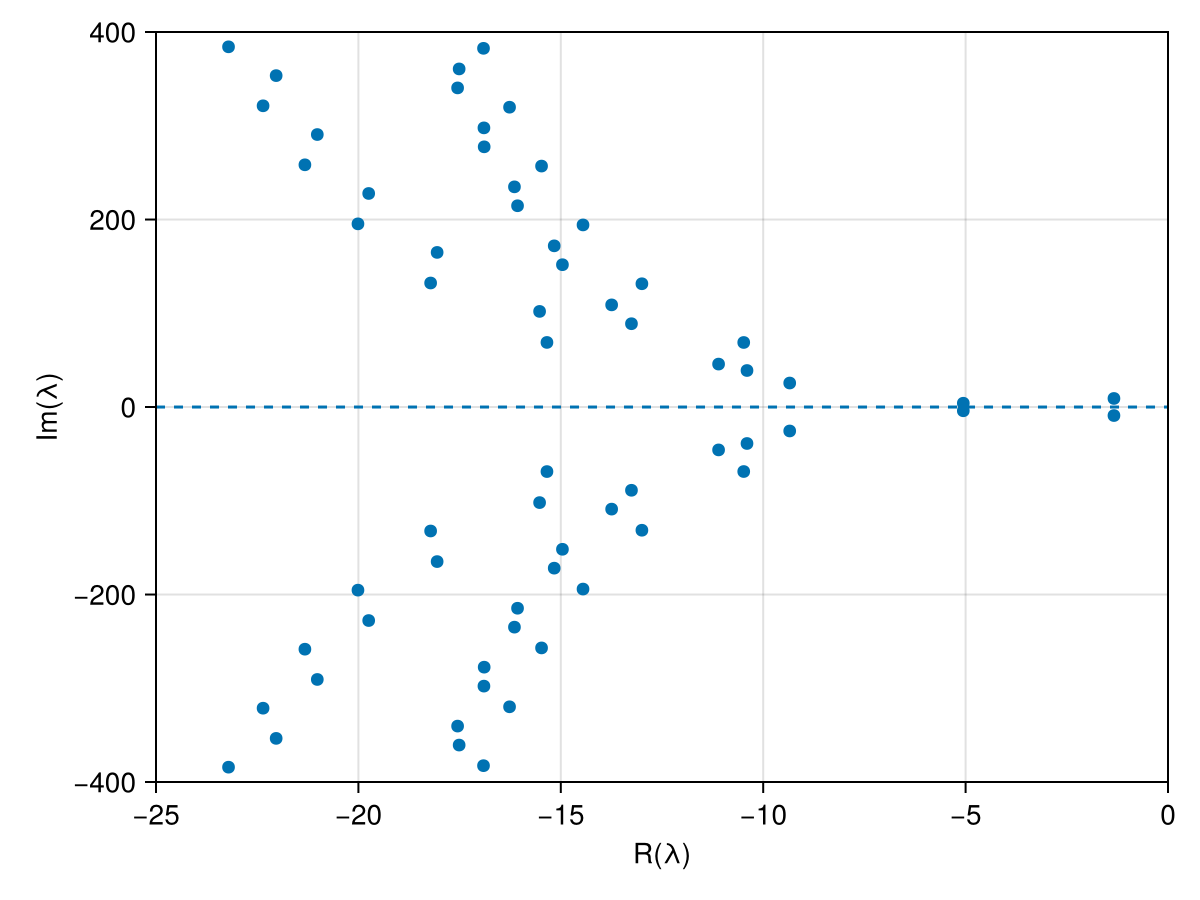

In [ ]:
neigs=length(eigvals1) #number of eigenvalues 

vjvec=[fill(0.0+0*im, m1) for _ in 1:neigs] #creates blank array for first eigenvector for the eigenvalues

for i in 1:neigs
    vjvec[i]=eigvecs1[:,i][1:m1] #finds first eigenvector for the eigenvalues
end 

stab_err=fill(NaN, neigs) #creates blank array for the error of stab_func_DDE
Idm1=Matrix{Float64}(I,m1,m1) #creates 2x2 identity matrix 

for k in 1:neigs
    ceq_vec=(eigvals1[k]*Idm1 - A0_1 - A1_1*exp(-(eigvals1[k]*tau1_1))- A2_1*exp(-(eigvals1[k]*tau2_1)))*vjvec[k] #finds the value of Equation (4) 
    comp_vec=ceq_vec-[0,0] #finds the difference between value of LHS of Equation (4) for given eigenvalue and eigenvector and the true value [0,0]
    stab_err[k]=norm(comp_vec) #finds the error of stab_func_DDE for chosen eigenvalue and eigenvector
end 

#Assume we accept a tolerance of 10^-7 (1e-7) from 0, we find all eigenvalues that are at least of this tolerance
stab_acc_indx=findall(<=(1e-7),stab_err) #finds indices of eigenvalues that are at least of accuracy 1e-7
eig_acc=eigvals1[stab_acc_indx] #eigenvalues that are at least 1e-7 accurate 

#Plot of eigenvalues that are at least 1e-7 accurate
fig1=Figure()
ax1=Axis(fig1[1,1],xlabel="R(λ)",ylabel="Im(λ)")
scatter!(ax1,real(eig_acc),imag(eig_acc))
hlines!(ax1,0, linestyle=:dash)
ylims!(ax1,[-400,400])
xlims!(ax1,[-25,0])
fig1

In [4]:
length(stab_acc_indx) #number of eigenvalues that are at least 1e-7 accurate

64

The number of eigenvalues that are within $10^{-7}$ tolerance of fulfilling Equation (4) for ```stab_func_DDE``` in this example is 64 out of 86. The expected number of values that should be rejected/ignored for this method is about half so this shows that ```stab_func_DDE``` works as expected as more than half can be accepted for a tolerance of $10^{-7}$. It is important to check that the $N$ value gives a good acceptance rate. Note that a higher value for $N$ gives a better number of eigenvalues within a wanted tolerance.

# Example 2

For the next example, we'll look at the DDE system that models the interaction between two neurons. This example is the main demo for demonstrating the use of MATLAB's DDE-Biftool, so comparisons can easily be drawn and the accuracy of ```stab_func_DDE``` can be explored. The neuron example's DDE system is (*DDE-BIFTOOL demo 1 - Neuron*, 2014):
```math
\begin{align*}
  \dot{x}_1&= -\kappa x_1(t) + \beta \tanh(x_1(t-\tau_s)) + a_{12} \tanh(x_2(t-\tau_2))\\
  \dot{x}_2&=-\kappa x_2(t) + \beta \tanh(x_2(t-\tau_s)) + a_{21} \tanh(x_2(t-\tau_1))
\end{align*}
```
For this system there is an equilibrium at (0,0). Hence for this equilibrium point, the DDE system can be linearised into the form:
```math
\dot{u}=A_0u(t) +A_1u(t-\tau_1) +A_2 u(t-\tau_2) +A_3 u(t-\tau_s)
```
where $u=(x_1,x_2)$ (linearised) and the matrices $A_0, A_1,A_2, A_3$ (to be put in ```A```) are given by:
```math
A_0=\begin{bmatrix} -\kappa & 0\\0&-\kappa \end{bmatrix}, \quad A_1=\begin{bmatrix} 0&0\\a_{21}sech^2(0)&0\end{bmatrix}, \quad A_2=\begin{bmatrix} 0&a_{12}sech^2(0)\\0&0\end{bmatrix}, \quad A_3=\begin{bmatrix} \beta sech^2(0) &0\\0 &\beta sech^2(0)\end{bmatrix}
```
Hence for equilibrium (0,0) we have the following matrices:
```math
A_0=\begin{bmatrix} -\kappa & 0\\0&-\kappa \end{bmatrix}, \quad A_1=\begin{bmatrix} 0&0\\a_{21}&0\end{bmatrix}, \quad A_2=\begin{bmatrix} 0&a_{12}\\0&0\end{bmatrix}, \quad A_3=\begin{bmatrix} \beta &0\\0 &\beta \end{bmatrix}
```
The demo for DDE-Biftool uses the following parameter values: $\kappa=0.5, \beta=-1, a_{12}=1, a_{21}=2.34, \tau_1=\tau_2=0.2, \tau_s=1.5$. So for the given parameters we the following matrices to put into argument ```A``` of ```stab_func_DDE```:
```math
A_0=\begin{bmatrix} -0.5 & 0\\0&-0.5 \end{bmatrix}, \quad A_1=\begin{bmatrix} 0&0\\2.34&0\end{bmatrix}, \quad A_2=\begin{bmatrix} 0&1\\0&0\end{bmatrix}, \quad A_3=\begin{bmatrix} -1 &0\\0 &-1\end{bmatrix}
```

In [ ]:
m2=2 #2 dimensional system (x1,x2)

#Below are the matrices to put into stab_func_DDE (for the parameters given above)
A0_2=[-0.5 0;0 -0.5]
A1_2=[0 0; 2.34 0]
A2_2=[0 1.0; 0 0]
A3_2=[-1.0 0; 0 1]

#The delays of system
tau1_2=0.2
tau2_2=0.2 
taus_2=1.5
N2=30 #31 interpolation points

stab2, eigvals2, eigvecs2=stab_func_DDE([A0_2, A1_2, A2_2, A3_2],[tau1_2, tau2_2, taus_2],N2, eigvecs=1) #the function outputs the stability, eigenvalues and eigenvectors (as eigvecs≠0)

(0, ComplexF64[-94.31515813195732 + 0.0im, -86.68778319379646 - 29.425257141090384im, -86.68778319379646 + 29.425257141090384im, -67.45286404930283 - 49.932506454931826im, -67.45286404930283 + 49.932506454931826im, -44.667514261837866 - 57.624999972782746im, -44.667514261837866 + 57.624999972782746im, -26.696942969410102 - 55.40863018600654im, -26.696942969410102 + 55.40863018600654im, -26.69327969781729 - 103.98433174908459im  …  -1.4823610544348669 + 9.343019533397943im, -1.299843075903278 - 7.257711791837343im, -1.299843075903278 + 7.257711791837343im, -1.074313613752384 - 5.198329884340603im, -1.074313613752384 + 5.198329884340603im, -0.799873578663028 - 3.1771433235921815im, -0.799873578663028 + 3.1771433235921815im, -0.4694040325058935 - 1.1578244934657076im, -0.4694040325058935 + 1.1578244934657076im, 0.8280248525225931 + 0.0im], ComplexF64[-0.008681668573870573 + 0.0im 8.950684325313337e-6 - 1.5078928421676537e-5im … 0.015237000761091695 - 0.09097775859776705im 0.12933133587521

The stability indicator is `0` so for the chosen parameters the equilibrium point is unstable.

Again we check the accuracy of ```stab_func_DDE``` by substituting all eigenvalues and their first eigenvector into Equation (4):

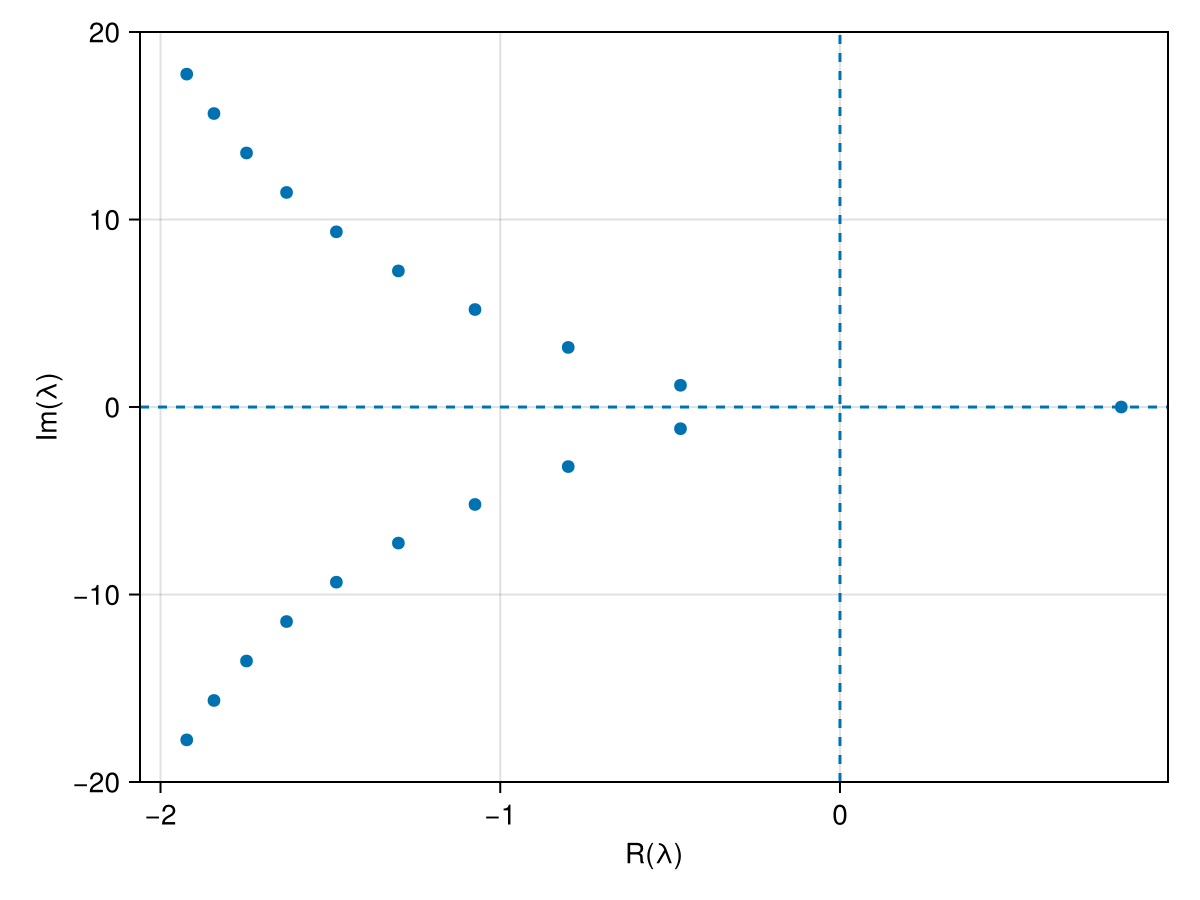

In [ ]:
neigs2=length(eigvals2) #number of eigenvalues 

vjvec2=[fill(0.0+0*im, m2) for _ in 1:neigs2] #creates blank array for first eigenvector for the eigenvalues

for i in 1:neigs2
    vjvec2[i]=eigvecs2[:,i][1:m2] #finds first eigenvector for the eigenvalues
end 

stab2_err=fill(NaN, neigs2) #creates blank array for the error of stab_func_DDE
Idm2=Matrix{Float64}(I,m2,m2) #creates 2x2 identity matrix 

for k in 1:neigs2
    ceq_vec2=(eigvals2[k]*Idm2 - A0_2 - A1_2*exp(-(eigvals2[k]*tau1_2))- A2_2*exp(-(eigvals2[k]*tau2_2))-A3_2*exp(-(eigvals2[k]*taus_2)))*vjvec2[k] #finds the value of Equation (4) 
    comp_vec2=ceq_vec2-[0,0] #finds the difference between value of LHS of Equation (4) for given eigenvalue and eigenvector and the true value [0,0]
    stab2_err[k]=norm(comp_vec2) #finds the error of stab_func_DDE for chosen eigenvalue and eigenvector
end 

#Assume we accept a tolerance of 10^-7 (1e-7) from 0 we find all eigenvalues that are at least of this tolerance
stab2_acc_indx=findall(<=(1e-7),stab2_err) #finds indices of eigenvalues that are at least of accuracy 1e-7
eig2_acc=eigvals2[stab2_acc_indx] #eigenvalues that are at least 1e-7 accurate 

#Plot of eigenvalues that are at least 1e-7 accurate
fig2=Figure()
ax2=Axis(fig2[1,1],xlabel="R(λ)",ylabel="Im(λ)")
scatter!(ax2,real(eig2_acc),imag(eig2_acc))
hlines!(ax2,0, linestyle=:dash)
vlines!(ax2,0, linestyle=:dash)
ylims!(ax2,[-20,20])
fig2

In [7]:
length(stab2_acc_indx) #number of eigenvalues that are at least 1e-7 accurate

19

Again we see that more than half the eigenvalues are at a suitable accuracy so ```stab_func_DDE``` is pretty accurate and working well for this function when using at least 31 interpolation points.

# Example 3

For the final example we will look at the Mackey-Glass equation. It is 1-dimensional and has a single delay. Again Mackey-Glass is an example demo in DDE-Biftool. The Mackey-Glass equation is (Manjunath, Raina 2014):
```math
\begin{align*}
  \dot{x}&= \frac{\beta x(t-\tau)}{1+[x(t-\tau)]^n}- \gamma x(t)\\
\end{align*}
```
For this system there is an equilibrium at $x^*=0$ and at $x^*=\left( \frac{\beta - \gamma}{\gamma}\right)^{\frac{1}{n}}$. For this example, we'll take $x^*=\left( \frac{\beta - \gamma}{\gamma}\right)^{\frac{1}{n}}$. In the demo for DDE-Biftool, the parameter values are: $\gamma=1, \beta=2, n=10$. I'll pick $\tau=0.2$. Hence for the equilibrium point $x^*=\left( \frac{\beta - \gamma}{\gamma}\right)^{\frac{1}{n}}=1$, the DDE system can be linearised into the form:
```math
\dot{u}=A_0u(t) +A_1u(t-\tau)
```
where $u=x$ (linearised) and the matrices $A_0, A_1$ (to be put in ```A```) are given by:
```math
A_0=-\gamma, \quad A_1=-\beta\left[\frac{(n-1)(1)^{n}-1}{(1+(1)^n)^2}\right]
```
So for the given parameters we the following matrices to put into argument ```A``` of ```stab_func_DDE```:
```math
A_0=-1, \quad A_1=-4
```

In [ ]:
m3=1 #1 dimensional system (x)

#Below are the matrices to put into stab_func_DDE (for the parameters given above)
A0_3=[-1] #needs to be in vector form
A1_3=[-4] #needs to be in vector form

#The delay of the system
tau1_3=0.2

N3=165 #166 interpolation points

stab3, eigvals3, eigvecs3=stab_func_DDE([A0_3, A1_3],[tau1_3],N3, eigvecs=1) #the function outputs the stability, eigenvalues and eigenvectors (as eigvecs≠0)

(1, ComplexF64[-11345.331966841411 - 2395.8680818159983im, -11345.331966841411 + 2395.8680818159983im, -8516.918341080673 - 5710.954118433302im, -8516.918341080673 + 5710.954118433302im, -6127.082405356333 - 23343.33957151325im, -6127.082405356333 + 23343.33957151325im, -5270.21950527869 - 6492.541631814im, -5270.21950527869 + 6492.541631814im, -3053.8249778551776 - 5912.627726372193im, -3053.8249778551776 + 5912.627726372193im  …  -17.554934633014895 - 132.89803627675576im, -17.554934633014895 + 132.89803627675576im, -16.217482752601242 - 101.35663669912509im, -16.217482752601242 + 101.35663669912509im, -14.382653933187818 - 69.73786206824286im, -14.382653933187818 + 69.73786206824286im, -11.429223084983045 - 37.928203712291996im, -11.429223084983045 + 37.928203712291996im, -2.671313571249901 - 6.61695176539855im, -2.671313571249901 + 6.61695176539855im], ComplexF64[-0.00024605079377283163 + 5.196473842874903e-5im -0.00024605079377283163 - 5.196473842874903e-5im … -0.01404707153987162

The stability indicator is `1` so for the given parameter values the equilibrium point $x^*=1$ is stable.

Again we check the accuracy of ```stab_func_DDE``` by substituting all eigenvalues and their first eigenvector into Equation (4):

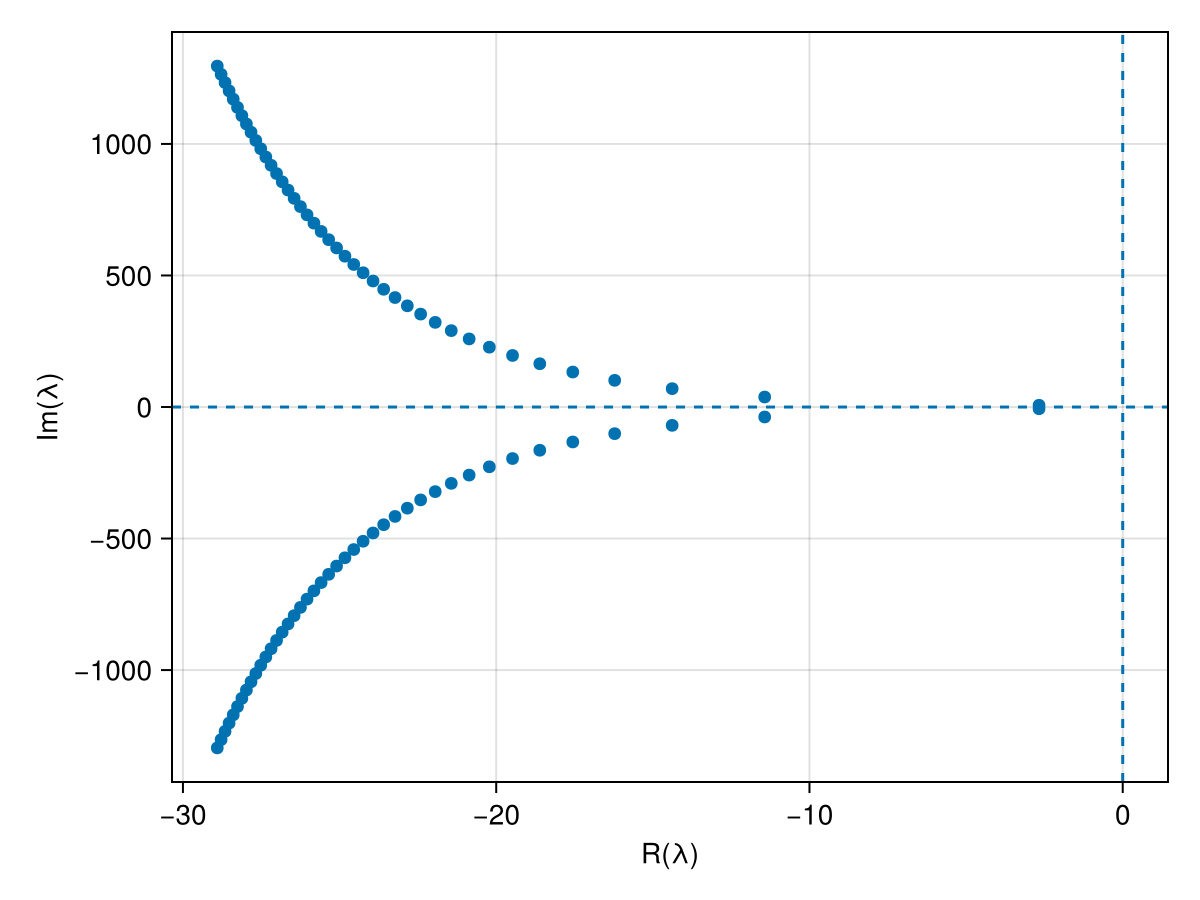

In [ ]:
neigs3=length(eigvals3) #number of eigenvalues 

vjvec3=[fill(0.0+0*im, m3) for _ in 1:neigs3] #creates blank array for first eigenvector for the eigenvalues

for i in 1:neigs3
    vjvec3[i]=eigvecs3[:,i][1:m3] #finds first eigenvector for the eigenvalues
end 

stab3_err=fill(NaN, neigs3) #creates blank array for the error of stab_func_DDE
Idm3=Matrix{Float64}(I,m3,m3) #creates 1x1 identity matrix 

for k in 1:neigs3
    ceq_vec3=(eigvals3[k]*Idm3 - A0_3 - A1_3*exp(-(eigvals3[k]*tau1_3)))*vjvec3[k] #finds the value of Equation (4) 
    comp_vec3=ceq_vec3-[0] #finds the difference between value of LHS of Equation (4) for given eigenvalue and eigenvector and the true value [0]
    stab3_err[k]=norm(comp_vec3) #finds the error of stab_func_DDE for chosen eigenvalue and eigenvector
end 

#Assume we accept a tolerance of 10^-7 (1e-7) from 0 we find all eigenvalues that are at least of this tolerance
stab3_acc_indx=findall(<=(1e-7),stab3_err) #finds indices of eigenvalues that are at least of accuracy 1e-7
eig3_acc=eigvals3[stab3_acc_indx] #eigenvalues that are at least 1e-7 accurate 

#Plot of eigenvalues that are at least 1e-7 accurate
fig3=Figure()
ax3=Axis(fig3[1,1],xlabel="R(λ)",ylabel="Im(λ)")
scatter!(ax3,real(eig3_acc),imag(eig3_acc))
hlines!(ax3,0, linestyle=:dash)
vlines!(ax3,0, linestyle=:dash)
fig3

In [19]:
length(stab3_acc_indx)

84

It is important to try to ensure that at least half of the eigenvalues outputted fulfil Equation (4), which for $N=165$ they do. The number $N$ will often depend on the smoothness of the curve (a smoother curve will often require a lower $N$).

# Limitation of `stab_func_DDE`

One slight limitation of `stab_func_DDE` to note is that the function can't cope with a large $N$ and small $\tau$ being used together. The interpolation nodes it finds are too similar to each other with some also too close to 0. This means the weights found in `j_eval` (internal function in `stab_func_DDE`) can be infinity, meaning the function breaks down. Despite this limitation, `stab_func_DDE` is good for finding stability of points with small $\tau$ if $N$ is lowered accordingly.

## References 

1. *DDE-BIFTOOL demo 1 - Neuron* (12/2014). Available at https://ddebiftool.sourceforge.net/demos/neuron/html/demo1.html (Accessed: 29 August 2025)
2. Berrut J.-P., Trefethen L.N. (2004). 'Barycentric Lagrange Interpolation', *SIAM Review*, Vol 46, No.3, pp. 501-517. Available at: https://www.jstor.org/stable/20453536 
3. Breda D., Maset S. and Vermiglio R. (2009). 'TRACE-DDE: a Tool for Robust Analysis and Characteristic Equations for Delay Differential Equations', *Lecture Notes in Control And Information Sciences*, volume 388, pp 145-155. Available at: http://dx.doi.org/10.1007/978-3-642-02897-7_13
4. Manjunath S. and Raina G. (2014) . 'Stability and Hopf bifurcation analysis of the Mackey-Glass and Lasota equations'. *The 26th Chinese Control and Decision Conference (2014 CCDC)*, pp. 2076–2082. Available at: https://doi.org/10.1109/CCDC.2014.6852509